In [178]:
#Import deps 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
# ... 

### Introduction
What makes the perfect bottle of wine? 

Wine is a major industry, with sales projected to steadily grow beyond $40 billion USD by 2029. [Source](https://www.statista.com/statistics/922403/global-wine-market-size/)

For the longest time, the secrets of the timeless art of winemaking were restricted to the intuitions and implicit knowledge of the vintners themselves. Today it is possible to apply the techniques of machine learning to analyze the chemical components of wine to determine how they influence the quality rating of the wine.

This study conducts machine learning analysis on the chemical constitutents of 6497 different wines (1599 reds and 4898 white ) to identify the predictive relationships between these features and wine quality. 

The purpose of this study is to show how machine learning can be applied to commercial pursuits and potentially improve sales and production quality of products. 


In [213]:
# Import Data 
#Drop wine type from the get-go. May change later
all_wine_raw_df = pd.read_csv('./Wine_data_both.csv').drop(columns=['Wine'])
red_wine_df = pd.read_csv('./Wine_data_red.csv')
white_wine_df = pd.read_csv('./Wine_data_white.csv')


In [247]:
# Inspect raw data 
print('All wine data types', all_wine_raw_df.info())
print('all wine value counts', all_wine_raw_df['quality'].value_counts())
# Try separating red and white or wine types 
display(all_wine_raw_df)

<class 'pandas.core.frame.DataFrame'>
Index: 5991 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5991 non-null   float64
 1   volatile acidity      5991 non-null   float64
 2   citric acid           5991 non-null   float64
 3   residual sugar        5991 non-null   float64
 4   chlorides             5991 non-null   float64
 5   free sulfur dioxide   5991 non-null   float64
 6   total sulfur dioxide  5991 non-null   float64
 7   density               5991 non-null   float64
 8   pH                    5991 non-null   float64
 9   sulphates             5991 non-null   float64
 10  alcohol               5991 non-null   float64
 11  quality               5991 non-null   int64  
 12  Outlier               5991 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 655.3 KB
All wine data types None
all wine value counts quality
6    2691
5    1994
7    

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Outlier
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,1
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,1
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,1
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


### Data Preparation, Encoding & Feature Engineering

One of the biggest challenges we faced was an significantly imbalanced data set. The minority classes, with quality =(3, 4, 9) were underepresented by several orders of magnitude compared to the majority class with quality=9 just having 5 samples and quality=6, the most frequent approx 3,000. 

Initial experiments were unable to come up with a model with sufficient sensitivity to predict minority classes with this sort of discrepancy. So we had to get clever. 

The cell below takes the mean values of the minority classes and uses it as the "typical value" for that class. Since 9 is so under-represented, it likely wouldn't be realistic to generalize from its average with only n=5 data points using SMOTE. So the decision was made to merge quality=8 into it. And do do the same for 3s and 4's. We argue this loss in target resolution is made up for improved model performance. 

Since our EDA discovered that our data had several outliers, we chose to remove these from the dataset. 
We decided to use the IsolationForest ML model to detect outliers rather than zscore or IQR

In [276]:
# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.01, n_estimators=400,  random_state=42)

# Fit the model
iso_forest.fit(all_wine_raw_df)

# Predict anomalies
outliers = iso_forest.predict(all_wine_raw_df)
# -1 for outliers, 1 for inliers

all_wine_raw_df['Outlier'] = outliers

# Filter out outliers

all_wine_raw_df = all_wine_raw_df[all_wine_raw_df['Outlier'] == 1].drop(columns=['Outlier'])


In [277]:
# Upgrade all 8s to become 9s and 3s to become 4s (binning)
all_wine_raw_df.loc[all_wine_raw_df['quality'] == 8, 'quality'] = 9
all_wine_raw_df.loc[all_wine_raw_df['quality'] == 3, 'quality'] = 4

all_9s = all_wine_raw_df[all_wine_raw_df['quality'] == 9]
all_4s = all_wine_raw_df[all_wine_raw_df['quality'] == 4]
all_6s = all_wine_raw_df[all_wine_raw_df['quality'] == 6]


mean_all_9s = all_9s.mean()
mean_all_4s = all_4s.mean()
mean_all_6s = all_6s.mean()
# Compare the means (difference between highest and lowest rated wines)
mean_difference_high_to_low = mean_all_9s - mean_all_4s
mean_difference_high_to_average = mean_all_9s - mean_all_6s

# Display the results
print("Mean values for highest rated wines (quality == 9):")
print(mean_all_9s)
print("\nMean values for lowest rated wines (quality == 3):")
print(mean_all_4s)
print("\nMean values for average rated wines (quality == 6):")
print(mean_all_6s)
print("\nDifference in mean values between highest and lowest:")
print(mean_difference_high_to_low)
print("\nDifference in mean values between highest and average:")
print(mean_difference_high_to_average)


Mean values for highest rated wines (quality == 9):
fixed acidity             6.921429
volatile acidity          0.256286
citric acid               0.328714
residual sugar            4.379286
chlorides                 0.038443
free sulfur dioxide      33.157143
total sulfur dioxide    118.742857
density                   0.992217
pH                        3.239429
sulphates                 0.494857
alcohol                  11.452857
quality                   9.000000
dtype: float64

Mean values for lowest rated wines (quality == 3):
fixed acidity             7.119565
volatile acidity          0.311467
citric acid               0.306848
residual sugar            4.573370
chlorides                 0.048261
free sulfur dioxide      22.038043
total sulfur dioxide    130.565217
density                   0.994436
pH                        3.193043
sulphates                 0.485978
alcohol                  10.078804
quality                   4.000000
dtype: float64

Mean values for average r

We then use the **generate_synthetic_samples** function to inject a number of statistically similar values into the sample set. 

It achieves this by using a multivariate normal distribution, which describes a set of random variables that may be correlated with each other, where each variable follows a normal distribution. 

In order realistially simulate the possibility of covariance between the different values of a single data entry, we pass the covariance matrix of the dataframe into np.random.multivariate_normal. It then multiplies this by a noise scale, ensuring that there the results resemble the average in the dataset without overly imitating it. 

In [278]:
def generate_synthetic_samples(mean_values, n_samples, noise_scale=0.03):
    synthetic_samples = np.random.multivariate_normal(
        mean=mean_values, 
        cov=all_wine_raw_df.cov() * noise_scale, 
        size=n_samples
    )
    return pd.DataFrame(synthetic_samples, columns=mean_values.index)
# Grab all the minority classes in the data and take their means, inject the magic # 30 
synthetic_9s = generate_synthetic_samples(mean_all_9s, 40)
print(all_6s, '6s')
print(synthetic_9s, 'synth')

synthetic_4s = generate_synthetic_samples(mean_all_4s, 40)
# Add the target column to the synthetic samples
synthetic_9s['quality'] = 9
synthetic_4s['quality'] = 4
# Combine synthetic samples with the original data
synthetic_data = pd.concat([synthetic_9s, synthetic_4s])
combined_data = pd.concat([all_wine_raw_df, synthetic_data])

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
5               8.1              0.28         0.40             6.9      0.050   
...             ...               ...          ...             ...        ...   
6484            7.5              0.31         0.41             2.4      0.065   
6486            7.2              0.66         0.33             2.5      0.068   
6490            6.3              0.51         0.13             2.3      0.076   
6494            6.3              0.51         0.13             2.3      0.076   
6496            6.0              0.31         0.47             3.6      0.067   

      free sulfur dioxide  

Below we repeat the steps performed a few cells above to verify that the values of the updated data still resemble what they were originally.  

In [218]:
all_9s = combined_data[combined_data['quality'] == 9]
all_4s = combined_data[combined_data['quality'] == 4]
all_6s = combined_data[combined_data['quality'] == 6]


synth_mean_all_9s = all_9s.mean()
synth_mean_all_4s = all_4s.mean()
# Compare the means (difference between highest and lowest rated wines)
synth_mean_difference_high_to_low = synth_mean_all_9s - synth_mean_all_4s
synth_mean_difference_high_to_average = mean_all_9s - mean_all_6s

# Display the results
print("Mean values for highest rated wines (quality == 9):")
print(synth_mean_all_9s)
print("\nMean values for lowest rated wines (quality == 3):")
print("\nMean values for average rated wines (quality == 6):")
print(mean_all_6s)
print("\nDifference in mean values between highest and lowest:")
print(synth_mean_difference_high_to_low)
print("\nDifference in mean values between highest and average:")
print(synth_mean_difference_high_to_average)


Mean values for highest rated wines (quality == 9):
fixed acidity             6.803953
volatile acidity          0.289154
citric acid               0.329674
residual sugar            5.349519
chlorides                 0.040206
free sulfur dioxide      34.722753
total sulfur dioxide    118.009082
density                   0.992414
pH                        3.227434
sulphates                 0.508304
alcohol                  11.696864
quality                   9.000000
dtype: float64

Mean values for lowest rated wines (quality == 3):

Mean values for average rated wines (quality == 6):
fixed acidity             7.166490
volatile acidity          0.312641
citric acid               0.322774
residual sugar            5.532023
chlorides                 0.053393
free sulfur dioxide      31.218562
total sulfur dioxide    115.623450
density                   0.994528
pH                        3.218278
sulphates                 0.530269
alcohol                  10.589054
quality                

Later, we apply cross validation techniques to verify the integrity of this synthetic data. 

In [279]:
# Manually encode the wine type, 0 is White, Red is 1
# Gretel.ai ---> Generating synthetic data 

# We dropped wine type for the time being
#combined_data['wine type'] = all_wine_raw_df['Wine'].map({'White': 0, 'Red': 1})

# Define the feature and target variables
# Note: We learned what features to drop through EDA and in the optimizations performed below. 
X = combined_data.drop(columns=['quality', 'citric acid', 'chlorides', 'density' ], axis=1)
y =  combined_data['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

Model with Outliers
              precision    recall  f1-score   support

           4       0.75      0.23      0.35        52
           5       0.69      0.70      0.69       423
           6       0.64      0.77      0.70       565
           7       0.69      0.49      0.57       214
           9       0.81      0.38      0.52        45

    accuracy                           0.67      1299
   macro avg       0.72      0.51      0.57      1299
weighted avg       0.67      0.67      0.66      1299

[[ 12  27  13   0   0]
 [  4 296 121   2   0]
 [  0 104 434  27   0]
 [  0   5 100 105   4]
 [  0   0  10  18  17]]
Model without Outliers
              precision    recall  f1-score   support

           4       0.93      0.26      0.41        53
           5       0.73      0.71      0.72       417
           6       0.62      0.80      0.70       550
           7       0.77      0.50      0.61       235
           9       0.88      0.34      0.49        44

    accuracy              

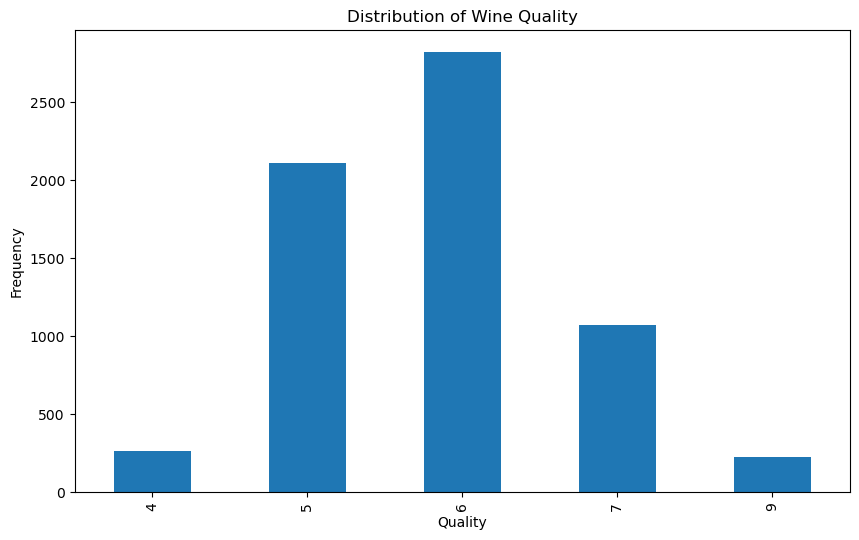

In [266]:
# Determine if data is balanced or imbalanced
plt.figure(figsize=(10, 6))
y.value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Quality')
plt.show()

# Clustering or feature engineering by clumping 3s/4s/5s/ low  6s/ medium/ 7,8,9 high quality 

Since our data is still very imbalanced, we want apply a few techniques to compensate for it. One method is to calculate class weights, which will help inform the model to learn more from the minority classes. 

In [267]:
# Since our data is very imbalanced, lets try calculating class weights 
unique_classes = np.array([4, 5, 6, 7, 9])
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(unique_classes, class_weights)}

print(f'Class weights: {class_weight_dict}')

Class weights: {4: 4.969377990430622, 5: 0.6152843601895734, 6: 0.4599645704162976, 7: 1.211901983663944, 9: 5.738121546961326}


Next we wanted to look into feature selection. We learned that the most significant features are 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', and 'alcohol'. 


In [268]:
# Feature Selection and regularization : What features can we drop? 
# Here we learned that density and pH could be dropped
# Initialize Lasso regression
lasso = Lasso(alpha=0.1)  
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lasso)
print(f'Mean Squared Error: {mse}')

# Check selected features
selected_features = X_train.columns[lasso.coef_ != 0]
print(f'Selected Features: {selected_features}')


# Calculate variance inflation factor for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Based on these results, we could consider dropping at least pH and density, and possibly also alcohol 

# Compute the correlation matrix
correlation_matrix = X.corr()

# Display the correlation matrix
print(correlation_matrix)


Mean Squared Error: 0.7321545332974203
Selected Features: Index(['residual sugar', 'free sulfur dioxide', 'total sulfur dioxide',
       'alcohol'],
      dtype='object')
Elastic Net Mean Squared Error: 0.9343007077842189
Elastic Net Coefficients: [-0.         -0.         -0.          0.00759258 -0.00210842  0.
  0.          0.        ]
                feature         VIF
0         fixed acidity   32.588047
1      volatile acidity    7.197255
2        residual sugar    3.320121
3   free sulfur dioxide    8.647710
4  total sulfur dioxide   13.127633
5                    pH  143.536215
6             sulphates   18.285189
7               alcohol   80.789337
                      fixed acidity  volatile acidity  residual sugar  \
fixed acidity              1.000000          0.211711       -0.120144   
volatile acidity           0.211711          1.000000       -0.209303   
residual sugar            -0.120144         -0.209303        1.000000   
free sulfur dioxide       -0.282931         -

In [280]:
# Note: Don't end up using, will likely drop
adasyn = ADASYN(random_state=42, n_neighbors=3)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

### Scaling the Data


In [281]:
# Note, scaling data seems to throw everything out here, probably because nothing in the data is measured in universal units.
# Will likey drop
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_resampled_scaled = scaler.fit_transform(X_resampled)
X_train_scaled = scaler.transform(X_train)
# Transform the testing data (use the same scaler fitted on the training data)
X_test_scaled = scaler.transform(X_test)

### Build Models

For our model we decided to use the versatile RandomizedTreeClassifier algorithm, which, after some experimentation with other algos proved to consistently give the best results.  

First, we did some hyperparameter tuning to try to find the best model. 

In [271]:
# Define a simpler parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
}


In [226]:
# Define the actual model code using what we've learned and search for a best model 

# Initialize RFC
rfc = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1 
)

# Perform the random search on the training data
random_search.fit(X_train, y_train)

# Get the best model
best_rfc = random_search.best_estimator_

# Predict on the scaled test data
y_pred_rfc = best_rfc.predict(X_test)

# Evaluate the best model
print("Best RFC Classification Report:")
print(classification_report(y_test, y_pred_rfc))
print("Best RFC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfc))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5,

In [284]:
print(best_rfc)
classifier = RandomForestClassifier(class_weight=class_weight_dict, criterion='log_loss', max_depth=30, max_features='log2', n_estimators=500, random_state=42)
classifier.fit(X=X_train, y=y_train)
y_pred_best = classifier.predict(X_test)

print("Best RFC Classification Report:")
print(classification_report(y_test, y_pred_best))
print("Best RFC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

RandomForestClassifier(class_weight={4: 4.969377990430622,
                                     5: 0.6152843601895734,
                                     6: 0.4599645704162976,
                                     7: 1.211901983663944,
                                     9: 5.738121546961326},
                       criterion='log_loss', max_depth=30, n_estimators=500,
                       random_state=42)
Best RFC Classification Report:
              precision    recall  f1-score   support

           4       0.92      0.46      0.62        26
           5       0.79      0.70      0.74       308
           6       0.70      0.88      0.78       460
           7       0.80      0.53      0.64       165
           9       1.00      0.41      0.58        22

    accuracy                           0.74       981
   macro avg       0.84      0.60      0.67       981
weighted avg       0.76      0.74      0.73       981

Best RFC Confusion Matrix:
[[ 12   6   8   0   0]
 [  1 216  86 

### Model Validation and Evaluation

Our model performs reasonably well for precision, however struggles with recall especially for the minority classes. 

#### Cross-Validation

Here we cross-validate the model using StratifiedKFold. We find that our cross validation scores are decent but not great.

In [285]:

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation when trained against synthetic data
cv_scores_synthetic_data = cross_val_score(best_rfc, X, y, cv=kfold, scoring='f1_weighted')

# Output the cross-validation scores against the da
print(f'Cross-Validation Score Against Synthetic Data: {cv_scores_synthetic_data}')
print(f'Mean Cross-Validation Score Against Synthetic Data: {np.mean(cv_scores_synthetic_data)}')


Cross-Validation Score Against Synthetic Data: [0.69960898 0.70210423 0.69809257 0.70946162 0.71684155]
Mean Cross-Validation Score Against Synthetic Data: 0.7052217921038615


#### A/B Testing

As a control experiment, we run the same model against the raw data. The model is generall less capable across the board, but most notably, is entirely unable to detect the minority classes (quality= 3 and quality=9)

In [286]:
raw_data = pd.read_csv('./Wine_data_both.csv') 
X_raw = raw_data.drop(columns=['quality', 'Wine'])
y_raw = raw_data['quality']
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw)
raw_classifier = RandomForestClassifier( class_weight=class_weight_dict, criterion='log_loss', max_depth=30, max_features='log2', n_estimators=500, random_state=42)
raw_classifier.fit(X=X_train_raw, y=y_train_raw)
y_pred_best_raw = raw_classifier.predict(X_test_raw)

print("Raw Data RFC Classification Report:")
print(classification_report(y_test_raw, y_pred_best_raw))
print("Raw Data Confusion Matrix:")
print(confusion_matrix(y_test_raw, y_pred_best_raw))

Raw Data RFC Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.75      0.14      0.24        43
           5       0.70      0.74      0.72       428
           6       0.64      0.77      0.70       567
           7       0.76      0.51      0.61       216
           8       0.86      0.31      0.45        39
           9       0.00      0.00      0.00         1

    accuracy                           0.68      1300
   macro avg       0.53      0.35      0.39      1300
weighted avg       0.69      0.68      0.67      1300

Raw Data Confusion Matrix:
[[  0   0   2   4   0   0   0]
 [  0   6  21  16   0   0   0]
 [  0   1 317 110   0   0   0]
 [  0   1 102 437  26   1   0]
 [  0   0   8  96 111   1   0]
 [  0   0   0  17  10  12   0]
 [  0   0   0   1   0   0   0]]


/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Evaluation & Interpretation 

Index(['fixed acidity', 'volatile acidity', 'residual sugar',
       'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates',
       'alcohol'],
      dtype='object')
[0.10332822 0.11599267 0.11440151 0.14860736 0.12395994 0.10626231
 0.09129405 0.19615393]


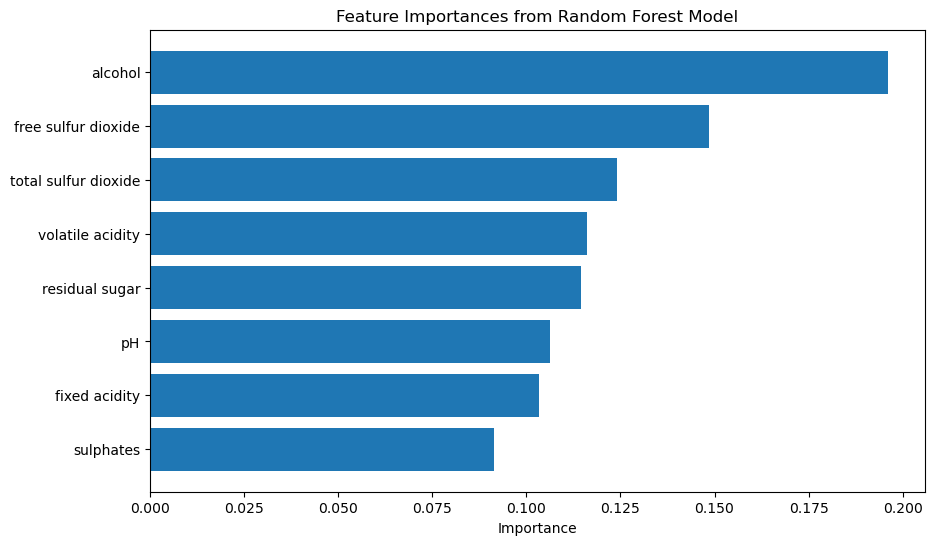

In [288]:
# Feature Importances: 
print(X_train.columns)
print(classifier.feature_importances_)
importances = classifier.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

Alcohol, and sulfur dioxide (free/total) are the three strongest predictors of wine quality. Interestingly, alcohol is the most important feature. This made us wonder if wine raters tended to perfer stronger wines.

In [299]:

for quality_class in all_wine_raw_df['quality'].sort_values().unique():
    mean_alcohol = all_wine_raw_df[all_wine_raw_df['quality'] == quality_class]['alcohol'].mean()
    print(f"Alcohol content of wines rated {quality_class}: {mean_alcohol}")

Alcohol content of wines rated 4: 10.078804347826088
Alcohol content of wines rated 5: 9.849478016024692
Alcohol content of wines rated 6: 10.598847826079567
Alcohol content of wines rated 7: 11.400586569575243
Alcohol content of wines rated 9: 11.452857142857143


Sure enough the more highly rated the wine the stronger the alcohol content, although this is not a simple linear relationship. 

We speculate that since wine rating is a subjective affair perhaps the graders are enjoying themselves a little bit more when they drink the stronger wines, hence this biases their judgement. 

In [300]:
print(all_wine_raw_df[all_wine_raw_df['quality'] == 9].mean() - all_wine_raw_df[all_wine_raw_df['quality'] == 4])

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
46         0.721429         -0.193714     0.068714       -0.020714  -0.024557   
189        0.421429         -0.023714     0.048714       -4.120714  -0.008557   
204        1.121429         -0.023714    -0.021286        2.079286  -0.014557   
278        0.121429         -0.063714    -0.011286        3.179286  -0.005557   
282        0.121429         -0.183714    -0.041286       -0.720714  -0.008557   
...             ...               ...          ...             ...        ...   
4483       1.121429         -0.023714     0.148714        3.179286  -0.019557   
4508       1.121429         -0.003714     0.028714        1.779286   0.004443   
4774      -0.178571          0.016286    -0.011286        3.179286  -0.006557   
5601      -0.578571         -0.123714    -0.151286        1.779286  -0.034557   
5770      -0.378571         -0.093714     0.088714        2.379286  -0.028557   

      free sulfur dioxide  